# Goal: verify ray noise model and experiment with simple detection algorithms

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import mpmath

from ray_delay.noise_model_patch import NoiseModelPatch
from ray_delay.noise_model import RayModelType
from stim_surface_code.memory import MemoryPatch
from stim_surface_code.patch import Qubit, DataQubit, MeasureQubit
import qc_utils.plot as plot_utils

In [2]:
dx = 7
dz = 7
dm = 7

patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
patch.noise_model.save_error_vals = True
patch.noise_params.cosmic_ray_params.model = RayModelType.DIRECT
patch.noise_params.cosmic_ray_params.max_strength = 0.995
center_qubit = patch.patch.device[dx][dz].idx

(<Axes: >, None)

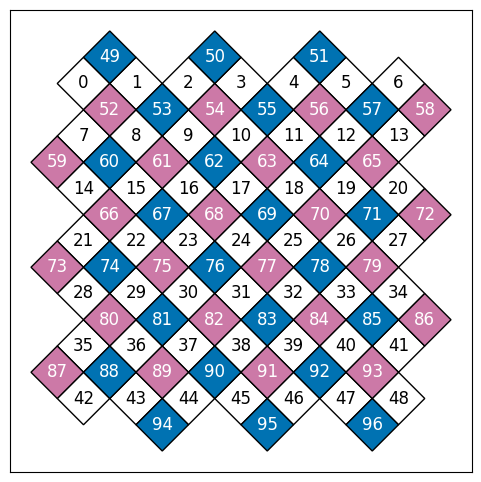

In [3]:
patch.patch.plot_qubit_vals()

In [4]:
ray_radius = 6
ray_qubit = center_qubit

# Getting baseline and cosmic-ray-induced detector fractions

In [5]:
syndrome_qubits = patch.patch.get_syndrome_qubits()

In [6]:
patch.reset()
# baseline_err_rate = patch.patch.count_logical_errors()[0]
baseline_fractions = np.mean(patch.patch.count_detection_events(10**6, return_full_data=True)[0], axis=0)

patch.force_cosmic_ray(ray_qubit, ray_radius)
# ray_err_rate = patch.patch.count_logical_errors()[0]
ray_fractions = np.mean(patch.patch.count_detection_events(10**6, return_full_data=True)[0], axis=0)

In [7]:
baseline_fractions_labeled = {q.idx: baseline_fractions[i] for i,q in enumerate(patch.patch.get_syndrome_qubits())}
ray_fractions_labeled = {q.idx: ray_fractions[i] for i,q in enumerate(patch.patch.get_syndrome_qubits())}

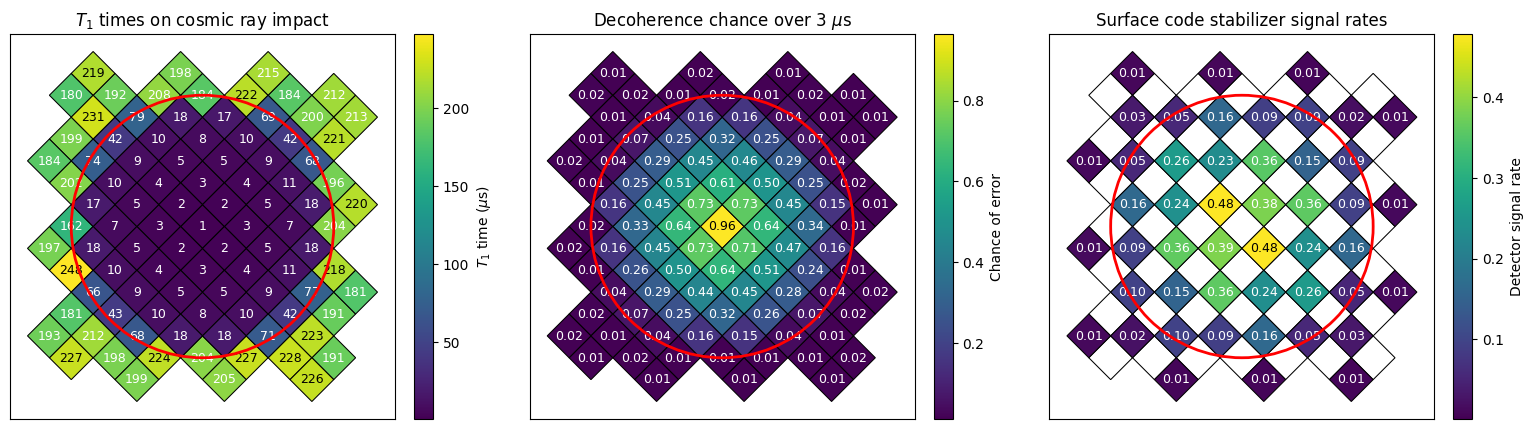

In [8]:
fig,ax = plt.subplots(1,3, figsize=(19, 5))

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,val in patch.noise_model.get_error_val_dict()['T1'].items():
    plot_vals[i] = val
_, cbar = patch.patch.plot_qubit_vals(plot_vals*1e6, ax=ax[0], font_size=9, plot_text='val', val_fmt_fn=lambda x: f'{x:0.0f}', cbar_kwargs={'size':0.01})
ax[0].add_patch(plt.Circle((patch.patch.qubit_name_dict[ray_qubit].coords[1], patch.patch.qubit_name_dict[ray_qubit].coords[0]), ray_radius, color='r', linewidth=2, zorder=10, fill=False))
# ax.plot([patch.patch.qubit_name_dict[ray_qubit].coords[1]], [patch.patch.qubit_name_dict[ray_qubit].coords[0]], 'x', color='r')
ax[0].set_title(r'$T_1$ times on cosmic ray impact')
cbar.set_label(r'$T_1$ time ($\mu$s)')

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,val in patch.noise_model.get_error_val_dict()['T1'].items():
    plot_vals[i] = 1 - np.exp(-3e-6/val)
_, cbar = patch.patch.plot_qubit_vals(plot_vals, ax=ax[1], font_size=9, plot_text='val', val_fmt_fn=lambda x: f'{x:0.2f}', cbar_kwargs={'size':0.01})
ax[1].add_patch(plt.Circle((patch.patch.qubit_name_dict[ray_qubit].coords[1], patch.patch.qubit_name_dict[ray_qubit].coords[0]), ray_radius, color='r', linewidth=2, zorder=10, fill=False))
ax[1].set_title(r'Decoherence chance over 3 $\mu$s')
cbar.set_label('Chance of error')

vmin = 1e-3
vmax = np.max(ray_fractions)
norm = mpl.colors.LogNorm
plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,qubit in enumerate(syndrome_qubits):
    plot_vals[qubit.idx] = ray_fractions[i]
_, cbar = patch.patch.plot_qubit_vals(qubit_vals=plot_vals, ax=ax[2], font_size=9, vmin=vmin, vmax=vmax, plot_text='val', val_fmt_fn=lambda x: f'{x:0.2f}', cbar_kwargs={'size':0.01})
ax[2].add_patch(plt.Circle((patch.patch.qubit_name_dict[ray_qubit].coords[1], patch.patch.qubit_name_dict[ray_qubit].coords[0]), ray_radius, color='r', linewidth=2, zorder=10, fill=False))
ax[2].set_title('Surface code stabilizer signal rates')
cbar.set_label('Detector signal rate')

plt.savefig('../figures/ray_model_direct.svg', bbox_inches='tight')

In [9]:
dx = 7
dz = 7
dm = 7

patch = NoiseModelPatch(MemoryPatch(dx, dz, dm), seed=0)
patch.noise_model.save_error_vals = True
patch.noise_params.cosmic_ray_params.model = RayModelType.SCRAMBLING
center_qubit = patch.patch.device[dx][dz].idx

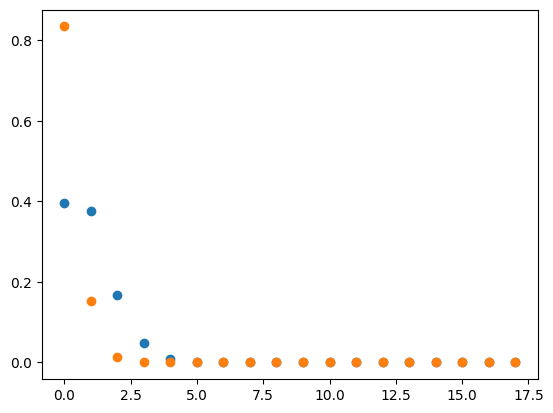

In [10]:
n = 18
counts = np.arange(n)
plt.plot(scipy.stats.binom.pmf(counts, n, 0.05), 'o')
plt.plot(scipy.stats.binom.pmf(counts, n, 0.01), 'o')

(<Axes: >, None)

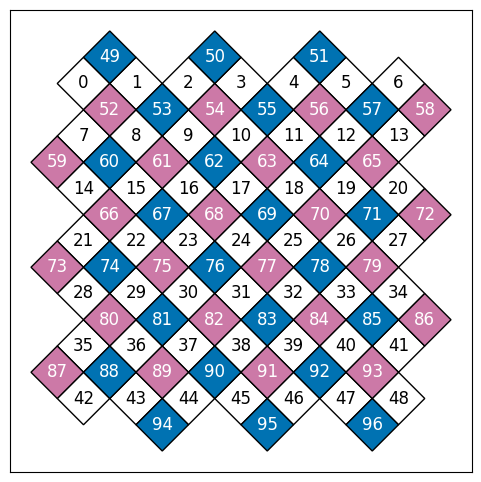

In [11]:
patch.patch.plot_qubit_vals()

In [12]:
ray_radius = 6
ray_qubit = center_qubit

In [13]:
syndrome_qubits = patch.patch.get_syndrome_qubits()

In [14]:
patch.reset()
# baseline_err_rate = patch.patch.count_logical_errors()[0]
baseline_fractions = np.mean(patch.patch.count_detection_events(10**6, return_full_data=True)[0], axis=0)

patch.force_cosmic_ray(ray_qubit, ray_radius)
# ray_err_rate = patch.patch.count_logical_errors()[0]
ray_fractions = np.mean(patch.patch.count_detection_events(10**6, return_full_data=True)[0], axis=0)

In [15]:
baseline_fractions_labeled = {q.idx: baseline_fractions[i] for i,q in enumerate(patch.patch.get_syndrome_qubits())}
ray_fractions_labeled = {q.idx: ray_fractions[i] for i,q in enumerate(patch.patch.get_syndrome_qubits())}

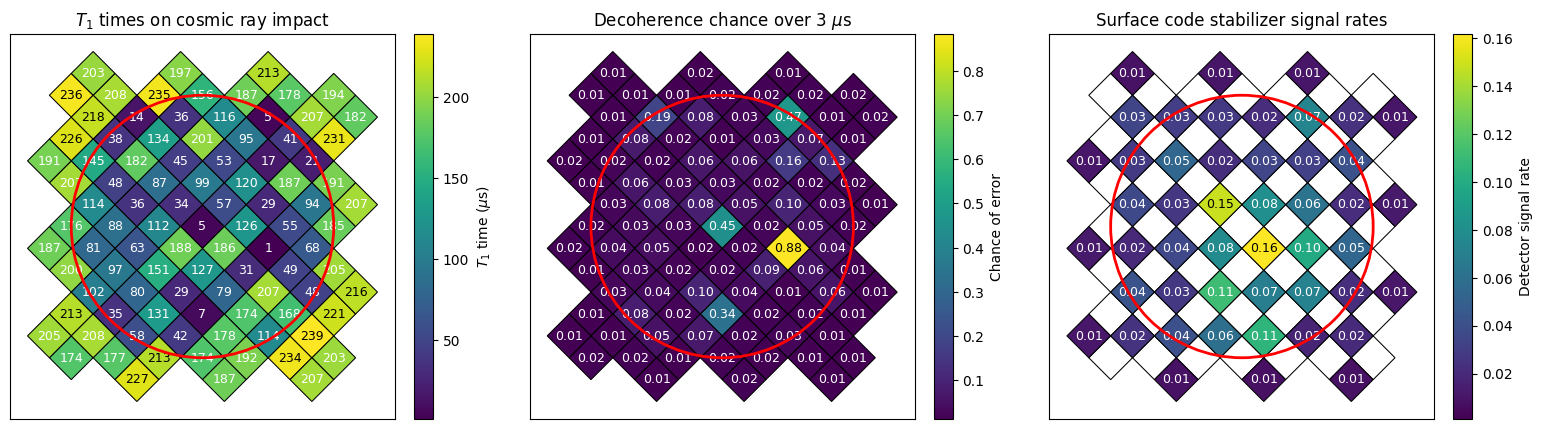

In [16]:
fig,ax = plt.subplots(1,3, figsize=(19, 5))

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,val in patch.noise_model.get_error_val_dict()['T1'].items():
    plot_vals[i] = val
_, cbar = patch.patch.plot_qubit_vals(plot_vals*1e6, ax=ax[0], font_size=9, plot_text='val', val_fmt_fn=lambda x: f'{x:0.0f}', cbar_kwargs={'size':0.01})
ax[0].add_patch(plt.Circle((patch.patch.qubit_name_dict[ray_qubit].coords[1], patch.patch.qubit_name_dict[ray_qubit].coords[0]), ray_radius, color='r', linewidth=2, zorder=10, fill=False))
# ax.plot([patch.patch.qubit_name_dict[ray_qubit].coords[1]], [patch.patch.qubit_name_dict[ray_qubit].coords[0]], 'x', color='r')
ax[0].set_title(r'$T_1$ times on cosmic ray impact')
cbar.set_label(r'$T_1$ time ($\mu$s)')

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,val in patch.noise_model.get_error_val_dict()['T1'].items():
    plot_vals[i] = 1 - np.exp(-3e-6/val)
_, cbar = patch.patch.plot_qubit_vals(plot_vals, ax=ax[1], font_size=9, plot_text='val', val_fmt_fn=lambda x: f'{x:0.2f}', cbar_kwargs={'size':0.01})
ax[1].add_patch(plt.Circle((patch.patch.qubit_name_dict[ray_qubit].coords[1], patch.patch.qubit_name_dict[ray_qubit].coords[0]), ray_radius, color='r', linewidth=2, zorder=10, fill=False))
ax[1].set_title(r'Decoherence chance over 3 $\mu$s')
cbar.set_label('Chance of error')

vmin = 1e-3
vmax = np.max(ray_fractions)
norm = mpl.colors.LogNorm
plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,qubit in enumerate(syndrome_qubits):
    plot_vals[qubit.idx] = ray_fractions[i]
_, cbar = patch.patch.plot_qubit_vals(qubit_vals=plot_vals, ax=ax[2], font_size=9, vmin=vmin, vmax=vmax, plot_text='val', val_fmt_fn=lambda x: f'{x:0.2f}', cbar_kwargs={'size':0.01})
ax[2].add_patch(plt.Circle((patch.patch.qubit_name_dict[ray_qubit].coords[1], patch.patch.qubit_name_dict[ray_qubit].coords[0]), ray_radius, color='r', linewidth=2, zorder=10, fill=False))
ax[2].set_title('Surface code stabilizer signal rates')
cbar.set_label('Detector signal rate')

# plt.tight_layout()
plt.savefig('../figures/ray_model_scrambling.svg', bbox_inches='tight')

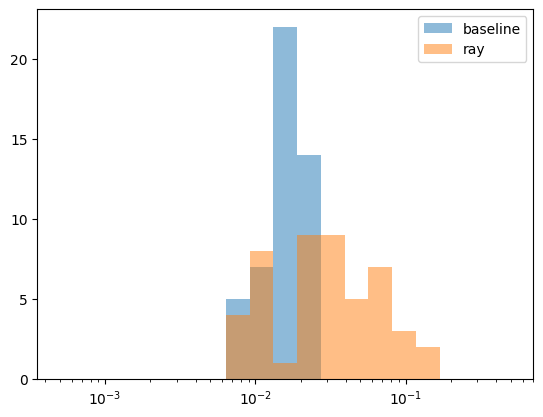

In [17]:
bins = np.geomspace(5e-4, 5e-1, 20)

plt.hist(baseline_fractions, bins, alpha=0.5, label='baseline')
plt.hist(ray_fractions, bins, alpha=0.5, label='ray')
plt.legend()
plt.xscale('log')
plt.show()

# Number of rounds required for a high-confidence prediction

### Spatio-temporal windows

Windows covering patch AND temporal syndrome history.

Parameters: temporal window $w_t$ and spatial window distance $w_s$.

In [18]:
def _initialize_windows(
        device: list[list[Qubit | None]],
        spatial_window_size: int,
    ) -> list[list[int]]:
    """Initialize spatial windows that we will use to detect cosmic rays.
    
    Args:
        device: The layout of the device, in the form of a 2D list of Qubit
            objects.
    """
    assert spatial_window_size < len(device) and spatial_window_size < len(device[0])
    window_rows = len(device) - spatial_window_size
    window_cols = len(device[0]) - spatial_window_size

    all_windows = []
    for wr in range(window_rows):
        for wc in range(window_cols):
            window_qubits = []
            for r in range(wr, wr + spatial_window_size + 1):
                for c in range(wc, wc + spatial_window_size + 1):
                    qb = device[r][c]
                    if isinstance(qb, MeasureQubit):
                        window_qubits.append(qb.idx)
            if len(window_qubits) > 0:
                all_windows.append(window_qubits)
    return all_windows

Metrics we care about for detection scheme:

- Confidence percentile ~= false negative rate (up to integer rounding)
    - Derived param: expected number of cycles / distillations / seconds per false trigger
- Average-case time-to-detection of ray
- Chance that it takes longer than one full distillation to detect a ray (~=
  chance of a bad T state being produced)
- Compute and memory overhead

In [19]:
cycles_per_distillation = 6*dm
max_latency = cycles_per_distillation

fprs = [1e-7, 1e-9, 1e-11]
for temporal_window_size in [6*dm]:
    for spatial_size in [1,2,6,2*dz]:
        detector_windows = _initialize_windows(patch.patch.device, spatial_size)

        signal_rates = np.zeros((len(fprs), max_latency, len(detector_windows)))
        false_positive_rates = np.zeros((len(fprs), max_latency, len(detector_windows)))
        detection_thresholds = np.zeros((len(fprs), max_latency, len(detector_windows)))
        for i,fpr in enumerate(fprs):
            # false positive rate per window to give total false positive rate
            window_fpr = 1 - (1-fpr)**(1/len(detector_windows))
            for latency in range(1, max_latency+1):
                j = latency - 1
                for k,window in enumerate(detector_windows):
                    baseline_mean = np.mean([baseline_fractions_labeled[q] for q in window]) # mean per qubit per round
                    ray_mean = np.mean([ray_fractions_labeled[q] for q in window])

                    # threshold of detections where we say it is outside of the baseline regime
                    detection_threshold = scipy.stats.binom.ppf(1-window_fpr, len(window)*temporal_window_size, baseline_mean)
                    detection_thresholds[i,j,k] = detection_threshold

                    # chance that baseline generates more than threshold detections
                    false_positive = 1-scipy.stats.binom.cdf(detection_threshold, len(window)*temporal_window_size, baseline_mean)
                    false_positive_rates[i,j,k] = false_positive
                
                    # chance that ray is detected
                    if latency <= temporal_window_size:
                        windowed_syndrome_rate = baseline_mean*(1-latency/temporal_window_size) + ray_mean*(latency/temporal_window_size)
                    else:
                        windowed_syndrome_rate = ray_mean
                    detection_prob = 1-scipy.stats.binom.cdf(detection_threshold, len(window)*temporal_window_size, windowed_syndrome_rate)
                    signal_rates[i,j,k] = detection_prob

        cumulative_signal_rates = 1-np.cumprod(np.prod(1-signal_rates, axis=2), axis=1)
        cumulative_false_positive_rates = 1-np.cumprod(np.prod(1-false_positive_rates, axis=2), axis=1)

        made_label = False
        for j in range(max_latency):
            if j % cycles_per_distillation == 0:
                if made_label:
                    plt.axvline(j, color='k', linestyle='-', alpha=0.5)
                else:
                    plt.axvline(j, color='k', linestyle='-', alpha=0.5, label='Distillation')
                    made_label = True
        
        plt.plot([-1,-1], [1,1], '--', color='gray', label='False positive (with no ray)')

        print(temporal_window_size, spatial_size, detection_thresholds[:,0,0])
        plt.plot(cumulative_signal_rates.T, '-', label=[f'fpr={f:0.1e}, avg. thresh={np.mean(detection_thresholds[i,0]):0.2f}' for i,f in enumerate(fprs)])
        plt.gca().set_prop_cycle(None)
        plt.plot(cumulative_false_positive_rates.T, '--')
        plt.legend()
        plt.xlim(0,max_latency)
        plt.title(f'Temporal window {temporal_window_size}, spatial window {spatial_size}\nAvg. syndromes per window {np.mean([len(w) for w in detector_windows]):0.2f}/{temporal_window_size*np.mean([len(w) for w in detector_windows]):0.2f}')
        plt.savefig(f'wt_{temporal_window_size}_ws_{spatial_size}.png')
        plt.close()


/Users/jchad/Library/Caches/pypoetry/virtualenvs/ray-delay-mG6OZh6y-py3.11/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:90: RuntimeWarning: overflow encountered in _binom_ppf
  return _boost._binom_ppf(q, n, p)


42 1 [ 8.  9. 10.]
42 2 [12. 13. 15.]
42 6 [30. 33. 36.]
42 14 [65. 71. 76.]


## Investigating specific window size

In [20]:
cycle_time = patch.patch.cycle_time
offline_time = 50e-3
# if we want to add X overhead, need (num_cycles + num_offline*offline_time) / num_cycles = X
# i.e. X*num_cycles = num_cycles + num_offline*offline_time
# i.e. X = 1 + num_offline/num_cycles * offline_time
# i.e. false_pos_rate = num_offline/num_cycles = (X-1)/offline_time

time_overhead = 1.1
print((time_overhead-1)/offline_time)

2.0000000000000018


In [21]:
mpmath.mp.dps = 50

cycles_per_distillation = 6*dm
max_latency = cycles_per_distillation

thresholds = [1-1e-11, 1-1e-13, 1-1e-15, 1-1e-16]
temporal_window_size = 50
spatial_size = 2

# just using it for its windows
detector_windows = _initialize_windows(patch.patch.device, spatial_size)

signal_rates = np.zeros((len(thresholds), max_latency, len(detector_windows)), dtype=mpmath.mpf)
syndrome_rates = np.zeros((len(thresholds), max_latency, len(detector_windows)), dtype=float)
false_positive_rates = np.zeros((len(thresholds), max_latency, len(detector_windows)), dtype=mpmath.mpf)
detection_thresholds = np.zeros((len(thresholds), max_latency, len(detector_windows)), dtype=int)
for i,threshold in enumerate(thresholds):
    for latency in range(1, max_latency+1):
        j = latency - 1
        for k,window in enumerate(detector_windows):
            baseline_mean = np.mean([baseline_fractions_labeled[q] for q in window]) # mean per qubit per round
            ray_mean = np.mean([ray_fractions_labeled[q] for q in window])

            # threshold of detections where we say it is outside of the baseline regime
            detection_threshold = scipy.stats.binom.ppf(threshold, len(window)*temporal_window_size, baseline_mean)
            detection_thresholds[i,j,k] = detection_threshold

            # chance that baseline generates more than threshold detections
            false_positive = 1-scipy.stats.binom.cdf(detection_threshold, len(window)*temporal_window_size, baseline_mean)
            false_positive_rates[i,j,k] = mpmath.mpf(false_positive)
        
            if latency <= temporal_window_size:
                # some part of window is at baseline rate (before ray has hit)
                windowed_syndrome_rate = baseline_mean*(1-latency/temporal_window_size) + ray_mean*(latency/temporal_window_size)
            else:
                windowed_syndrome_rate = ray_mean
            syndrome_rates[i,j,k] = mpmath.mpf(windowed_syndrome_rate)
            detection_prob = 1-scipy.stats.binom.cdf(detection_threshold, len(window)*temporal_window_size, windowed_syndrome_rate)
            signal_rates[i,j,k] = mpmath.mpf(detection_prob)

cumulative_no_signal_rates = np.cumprod(np.prod(1-signal_rates, axis=2), axis=1)
cumulative_signal_rates = 1 - cumulative_no_signal_rates
cumulative_no_signal_rates_baseline = np.cumprod(np.prod(1-false_positive_rates, axis=2), axis=1)
cumulative_false_positive_rates = 1 - cumulative_no_signal_rates_baseline

In [22]:
signal_rates[0,0,0]

mpf('0.00000000000072686301422208998701535165309906005859375')

In [23]:
np.mean(detection_thresholds, axis=2)[:,0]

array([ 8.28571429,  9.32142857, 10.32142857, 10.79761905])

In [24]:
cumulative_no_signal_rates[:,-1]

array([mpf('0.97271615384328563136988002132286335827400308882818953'),
       mpf('0.9965418594395428163452267918261268964666339635995575'),
       mpf('0.9996440668308329570541067120824856852470441748096601'),
       mpf('0.99966146591399002939510436149268813757912091432696249')],
      dtype=object)

In [25]:
cumulative_false_positive_rates[:,-1].astype(float)

array([1.47881866e-08, 1.81546778e-10, 2.11697326e-12, 2.79776202e-13])

Other aspect: we need to know where the ray is in order to turn off the correct
patches. Initial idea: take the first window that triggers and turn
off that patch, and then continue to monitor all windows (including those that
overlap with offline area). Any time a window triggers, turn off all areas that
it overlaps with. This will be the most conservative but should avoid any
potential issues.

Can simulate this by calculating window trigger rates for a cosmic ray centered
on a large patch, then convert to individual qubit trigger rates. Should only
depend on distance from ray. Then, when we simulate a ray impact at a specific
location, can calculate the chance of a patch being turned off based on the
chance of each of its qubits being turned off.

Alternatively, don't have windows that overlap between patches, and only turn
off a patch when one of its own windows triggers?


What is the cost function here? Want to maximize 

## Chance of each qubit being inside a triggered window

In [26]:
qubit_no_signal_rates = np.ones((len(thresholds), max_latency, len(patch.patch.all_qubits)), dtype=mpmath.mpf)
for i,threshold in enumerate(thresholds):
    for latency in range(1, max_latency+1):
        j = latency - 1
        for k,window in enumerate(detector_windows):
            signal_rate = signal_rates[i,j,k]
            for q in window:
                # measure qubit
                qubit_no_signal_rates[i,j,q] *= (1-signal_rate)
                # data qubits
                for data_q in patch.patch.qubit_name_dict[q].data_qubits:
                    if data_q is not None:
                        qubit_no_signal_rates[i,j,data_q.idx] *= (1-signal_rate)
qubit_no_signal_rates = np.prod(qubit_no_signal_rates, axis=(1))

/Users/jchad/Library/Caches/pypoetry/virtualenvs/ray-delay-mG6OZh6y-py3.11/lib/python3.11/site-packages/stim_surface_code/patch.py:1420: RuntimeWarning: invalid value encountered in scalar divide
  qubit_colors.append(cmap((val-vmin)/(vmax-vmin)))


Text(0.5, 1.0, 'Qubit chance of signal')

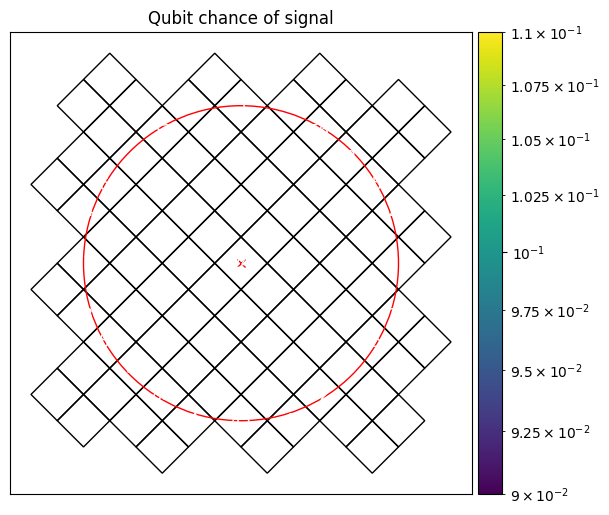

In [27]:
ax,_ = patch.patch.plot_qubit_vals(np.maximum(1e-1, (1-qubit_no_signal_rates)[-1].astype(float)), norm=mpl.colors.LogNorm)
ax.add_patch(plt.Circle((patch.patch.qubit_name_dict[ray_qubit].coords[1], patch.patch.qubit_name_dict[ray_qubit].coords[0]), ray_radius, color='r', fill=False))
ax.plot([patch.patch.qubit_name_dict[ray_qubit].coords[1]], [patch.patch.qubit_name_dict[ray_qubit].coords[0]], 'x', color='r')
ax.set_title('Qubit chance of signal')